# CoLlAGe Features

In [2]:
pip install -r py_collage_requeriments.txt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Could not fetch URL https://pypi.ngc.nvidia.com/collageradiomics/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='developer.download.nvidia.com', port=443): Max retries exceeded with url: /compute/redist/collageradiomics/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1007)'))) - skipping
Could not fetch URL https://pypi.ngc.nvidia.com/scikit-image/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='developer.download.nvidia.com', port=443): Max retries exceeded with url: /compute/redist/scikit-image/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1007)'))) - skipping
Could not fetch URL https://pypi.ngc.nvidia.com/scikit-build/: 

In [1]:
import os
import glob
import logging
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import nibabel as nib
import pandas as pd 

import collageradiomics 
print(collageradiomics.__name__)

from skimage.feature import greycomatrix, greycoprops

FORMAT = '%(asctime)-15s %(levelname)s %(funcName)s  %(message)s'
logging.basicConfig(format=FORMAT, level=logging.DEBUG)
root_path = '/app/Data/_Brain/Radiology/_Adult/_Glioma/' # server path
#root_path = 'Z:/Groups/IDIAGroup/Data/_Brain/Radiology/_Adult/_Glioma/' # local path

collageradiomics


# Functions

In [2]:
def getting_images_list(mri_data,subdir,time_point,mri_mod,pipeline,mask_str):
    
    outpath_base= root_path + mri_data + '/Feature_extraction/Radiomics_features/'
    print('main outpath ....... ',outpath_base)
    main_path=os.path.join(root_path , mri_data, subdir,'*',time_point, '*' + mask_str +'.nii.gz')
    print('main_path tumor labels.......',main_path)
    
    # masks with all the tumor labels
    labels = glob.glob(main_path)
    labels = sorted(labels)

    main_path=os.path.join(root_path , mri_data, subdir,'*',time_point, '*_'+ mri_mod + '*' + pipeline +'*.nii*')
    print('main_path MRI modality...',main_path)
    imgs = glob.glob(main_path)

    imgs=sorted(imgs)
    print('\n number of segmentation files: {}, number of MRI scans: {} , for MIR modality: {}'.format(len(labels), len(imgs), mri_mod))
 
    return outpath_base, main_path, labels, imgs

In [3]:
def getting_images_list_from_csv(mri_data,subdir,time_point,mri_mod,pipeline,mask_str):
    
    # read list of patients from a list CSV XLSX

    xlsx_path=root_path+'UCSF/UCSF-PDGM/Metadata/UCSF-Pre-Post-Os.xlsx'
    data_id=pd.read_excel(xlsx_path)
    ID=data_id['UCSF-PDGM_ID'].tolist()

    labels=[]

    for ids in ID:
        mask_file=glob.glob(os.path.join(root_path , mri_data, mri_data + '-PDGM' '/Preprocessed/*/time02/',ids +'*seg_brats.nii.gz'))
        #print(os.path.join(root_path , mri_data, mri_data + '-PDGM' '/Preprocessed/Post-Op/*/time01/',ids +'*seg_brats.nii.gz'))
        labels.append(mask_file[0])
        #print(mask_files)

    labels=sorted(labels)
    len(labels)
    return labels

In [4]:
def compute_collage_stats(collage,collage_output,clg_af,tm_dim):
    angle_output2=np.zeros((tm_dim[0],tm_dim[1],tm_dim[2],13,2))
    print('angle_output2.shape ....', angle_output2.shape)
    
    for a in range(collage_output.shape[4]):
        dom_angle = collage.dominant_angles[:,:,:,a]
        print('dom_angle.shape ....', dom_angle.shape)
        angle_output = collage._calculate_haralick_textures(dom_angle)
        print('angle_output.shape ....', angle_output.shape)
        angle_output2[:,:,:,:,a]=angle_output
        
        
        for f in range(collage_output.shape[3]):
            c = f*4
            if a >= 1:
                c = (13+f)*4

            feature_angle = angle_output[:,:,:,f]

            f_median = np.nanmedian(feature_angle)
            clg_af[c] = f_median

            f_var = np.nanvar(feature_angle)
            clg_af[c+1] = f_var

            feature_flat = feature_angle.reshape(-1)
            f_skew = st.skew(feature_flat, nan_policy='omit')
            f_skew = np.ma.getdata(f_skew)
            clg_af[c+2] = f_skew

            f_kurt = st.kurtosis(feature_flat, nan_policy='omit')
            clg_af[c+3] = f_kurt
        print('-----------------------------------------------')
    return clg_af, feature_angle, angle_output2

In [5]:
def plot_collage_map(mri_image, label, collage, mri_mod):

    # To show lesion mask overlaid on whole MRI
    z=np.where(label==1)
    zz = round(np.mean([np.min(z[2]),np.max(z[2])])) ### choose central slice

    new_image = mri_image[:,:,zz]
    new_label = label[:,:,zz]
    figure = plt.figure(figsize = (10, 10))
    extent = 0, new_image.shape[1], 0, new_image.shape[0]
    plt.imshow(new_image, cmap=plt.cm.gray, interpolation='none', extent=extent)
    plt.imshow(new_label, cmap=plt.cm.jet, alpha=0.5*(new_label>0), interpolation='none', extent=extent)
    plt.title('slide ' + str(zz))
    plt.savefig(output_name +'/plot_mri_mask_'+ id_label +'_'+ name_a +'_'+pipeline +'.png')

    # To show CoLlAGe feature heatmap overlaid on MRI zoomed in to the bounding box
    bb = zz-np.min(z[2])
    # which_angle = 0
    # angle0 = collage.dominant_angles[:,:,:,which_angle]
    # angle_output0 = collage._calculate_haralick_textures(angle0)

    # To show CoLlAGe feature heatmap overlaid on whole MRI
    which_feature = collageradiomics.HaralickFeature.SumVariance
    feature_output = collage.get_single_feature_output(which_feature)
    which_angle = 1
    feature_angle_imsize = feature_output[:,:,zz,which_angle]

    figure = plt.figure(figsize = (10, 10))
    extent = 0, new_image.shape[1], 0, mri_image.shape[0]
    plt.imshow(new_image, cmap=plt.cm.gray, extent=extent)
    plt.imshow(feature_angle_imsize, cmap=plt.cm.jet, alpha=0.5, extent=extent)
    plt.title('slide ' + str(zz))
    plt.savefig(output_name +'/'+ mri_mod +'_'+ 'plot_mri_clg_'+ id_label +'_'+ name_a +'_' + pipeline + '.png')

In [6]:
def plot_collage_map_bounding(mri_image, label, angle_output2, feature_index, clg_angle, bines,mri_mod,tmp_stats,nib_input, onset_sld=0):
    
    feature_list=['AngularSecondMoment','Contrast','Correlation',
                  'SumOfSquareVariance','SumAverage','SumVariance','SumEntropy',
                  'Entropy','DifferenceVariance','DifferenceEntropy',
                  'InformationMeasureOfCorrelation1','InformationMeasureOfCorrelation2',
                  'MaximalCorrelationCoefficient']
    feature=feature_list[feature_index]
    print(f" feature map for {feature} for main direction {clg_angle+1}")
    # To show lesion mask overlaid on whole MRI
    z=np.where(label==1)
    zz = round(np.mean([np.min(z[2]),np.max(z[2])])) ### choose central slice

    new_image = mri_image[:,:,zz]
    new_label = label[:,:,zz]
    # To show CoLlAGe feature heatmap overlaid on MRI zoomed in to the bounding box
    bb = zz-np.min(z[2])+onset_sld
    # which_angle = 0
    # angle0 = collage.dominant_angles[:,:,:,which_angle]
    # angle_output0 = collage._calculate_haralick_textures(angle0)
    haralick_feature_class = collageradiomics.HaralickFeature
    which_feature = getattr(haralick_feature_class, feature)
    print(f"which_feature {which_feature}")
    feature_angle_imbb = angle_output2[:,:,bb,which_feature,clg_angle]
    feature_angle_imbb = feature_angle_imbb / np.nanmax(feature_angle_imbb)

    figure = plt.figure(figsize = (10, 10))
    extent = 0, feature_angle_imbb.shape[1], 0, feature_angle_imbb.shape[0]
    min_y_bb = collage.mask_min_y
    max_y_bb = collage.mask_max_y
    min_x_bb = collage.mask_min_x
    max_x_bb = collage.mask_max_x
    min_z_bb = collage.mask_min_z
    max_z_bb = collage.mask_max_z
    plt.imshow(new_image[min_y_bb:max_y_bb,min_x_bb:max_x_bb], cmap=plt.cm.gray, extent=extent)
    plt.imshow(feature_angle_imbb, cmap=plt.cm.jet, alpha=0.5, extent=extent)
    plt.colorbar()
    
    if clg_angle == 0:
        feat_onset=0
    elif clg_angle == 1:
        feat_onset= angle_output2.shape[3]*4
        
    
    i= feature_index*4 + feat_onset
    median_val=tmp_stats[i]
    variance_val=tmp_stats[i+1]
    skewness_val=tmp_stats[i+2]
    kurtosis_val=tmp_stats[i+3]
        
    stats_text = f'Median: {median_val:.6f}\nVariance: {variance_val:.6f}\nSkewness: {skewness_val:.6f}\nKurtosis: {kurtosis_val:.6f}'
#         ax[0].text(0.15, 0.4, stats_text, fontsize=20, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))            
#         ax[0].set_title(names +'\n' + str(ws) +' bin '+ str(levels/binWidth))
    plt.title(stats_text,fontsize=18, loc='center')
    
    
    plt.savefig(output_name +'/'+ mri_mod +'_'+  id_label +'_'+feature+'_'+str(clg_angle+1)+'_'+ str(bines)+'_' + name_a + '_'+ pipeline +'.png')
    
    
    # mapping the feature map back to the image space and saving the result (nii.gz)
    
    image = nib_input.get_fdata()
    affine = nib_input.affine
    header = nib_input.header
    image_shape = image.shape
    
    feature_angle_imbb = angle_output2[:,:,:,which_feature,clg_angle]
    feature_angle_imbb= feature_angle_imbb/np.nanmax(feature_angle_imbb)
    print(f"feature_angle_imbb.shape , {feature_angle_imbb.shape}")
#     # revert the rotation if nedeed
#     feature_angle_imbb = np.rot90(np.fliplr(feature_angle_imbb))
    print(f"feature_angle_imbb corrected.shape , {feature_angle_imbb.shape}")
    
    MRI_map= np.zeros(image_shape, dtype=image.dtype)
    print(f" X shape {min_x_bb-max_x_bb} Y bb shape {min_y_bb-max_y_bb}  Z shape {min_z_bb-max_z_bb}")
    MRI_map[min_y_bb:max_y_bb,min_x_bb:max_x_bb, min_z_bb:max_z_bb] = feature_angle_imbb
    new_nifti = nib.Nifti1Image(MRI_map, affine, header)
    nib_name=output_name +'/'+ mri_mod +'_'+  id_label +'_'+feature+'_'+str(clg_angle+1)+'_'+ str(bines)+'_' + name_a + '_'+ pipeline +'.nii.gz'
    print(f"saving {os.path.basename(nib_name)}")
    nib.save(new_nifti, nib_name)

# Setting file naming and experimental params

In [180]:
# dir params
mri_mod='FLAIR'
mri_data='ESLOV'
subdir='Preprocessed'
time_point='time02'
pipeline='_SkullS_BiasCorrect_reg_IntSnd'
mask_str= 'SRI24_brats'

# Habitat params
label_val = 1

binWidth=list([32])

# Radiomics params

feature_family="Collage"
feature_folder="Collage"
plot_featMap=True

# batch params
id1=46
id2=id1+1

In [163]:
# Masks with BRATS convention. Select 0 for all the tumor habitat
if label_val == 4: 
    habitat='Enhancing'
    sufx='ET'
elif label_val == 2:
    habitat='Edema'
    sufx='ED'
elif label_val == 1:   
    habitat='Necrosis'
    sufx='NC'
elif label_val == 5:    
    habitat='All_tumor'
    sufx='TM'
  
name_a = f'{feature_family}_{habitat}'
name_a

'Collage_Edema'

# Set Directories 

In [181]:
outpath_base, main_path, labels, imgs=getting_images_list(mri_data,subdir,time_point,mri_mod,pipeline,mask_str)
(labels[id1:id2])

main outpath .......  /app/Data/_Brain/Radiology/_Adult/_Glioma/CCF/Feature_extraction/Radiomics_features/
main_path tumor labels....... /app/Data/_Brain/Radiology/_Adult/_Glioma/CCF/Preprocessed/*/Baseline/*SRI24_brats.nii.gz
main_path MRI modality... /app/Data/_Brain/Radiology/_Adult/_Glioma/CCF/Preprocessed/*/Baseline/*_T1c*SRI24_SkullS_BiasCorrect_IntStnd*.nii*

 number of segmentation files: 68, number of MRI scans: 67 , for MIR modality: T1c


['/app/Data/_Brain/Radiology/_Adult/_Glioma/CCF/Preprocessed/54/Baseline/54_01_All-label_SRI24_brats.nii.gz']

# run CoLlAGe

id_label (patient ID) ...........  54
time_point (time follow up) ...........  Baseline
output_name folder ....  /app/Data/_Brain/Radiology/_Adult/_Glioma/CCF/Feature_extraction/Radiomics_features/54/Baseline/collage_RSNA
tmp_name stats .npy ....... /app/Data/_Brain/Radiology/_Adult/_Glioma/CCF/Feature_extraction/Radiomics_features/54/Baseline/collage_RSNA/T1c_54_32_Collage_Edema_SRI24_SkullS_BiasCorrect_IntStnd.npy
tmp_name angles output .npy ....... /app/Data/_Brain/Radiology/_Adult/_Glioma/CCF/Feature_extraction/Radiomics_features/54/Baseline/collage_RSNA/T1c_54_32_Collage_Edema_SRI24_SkullS_BiasCorrect_IntStnd_angle_output.npy
label_vol . .....  13869


2024-11-20 03:54:17,599 DEBUG __init__  Collage Module Initialized
2024-11-20 03:54:17,600 DEBUG __init__  Running 3D Collage = True



CoLlAGe already exists (npy) Label 2 not found in mask for: 54


2024-11-20 03:54:18,010 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7f8234359f60>


0
 feature map for AngularSecondMoment for main direction 1
which_feature 0
feature_angle_imbb.shape , (31, 41, 40)
feature_angle_imbb corrected.shape , (31, 41, 40)
 X shape -41 Y bb shape -31  Z shape -40
saving T1c_54_AngularSecondMoment_1_32_Collage_Edema_SRI24_SkullS_BiasCorrect_IntStnd.nii.gz
1
 feature map for Contrast for main direction 1


2024-11-20 03:54:18,598 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7f8230eea7d0>


which_feature 1
feature_angle_imbb.shape , (31, 41, 40)
feature_angle_imbb corrected.shape , (31, 41, 40)
 X shape -41 Y bb shape -31  Z shape -40
saving T1c_54_Contrast_1_32_Collage_Edema_SRI24_SkullS_BiasCorrect_IntStnd.nii.gz
2
 feature map for Correlation for main direction 1


2024-11-20 03:54:19,175 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7f8233996290>


which_feature 2
feature_angle_imbb.shape , (31, 41, 40)
feature_angle_imbb corrected.shape , (31, 41, 40)
 X shape -41 Y bb shape -31  Z shape -40
saving T1c_54_Correlation_1_32_Collage_Edema_SRI24_SkullS_BiasCorrect_IntStnd.nii.gz


2024-11-20 03:54:20,170 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7f8230d13430>


3
 feature map for SumOfSquareVariance for main direction 1
which_feature 3
feature_angle_imbb.shape , (31, 41, 40)
feature_angle_imbb corrected.shape , (31, 41, 40)
 X shape -41 Y bb shape -31  Z shape -40
saving T1c_54_SumOfSquareVariance_1_32_Collage_Edema_SRI24_SkullS_BiasCorrect_IntStnd.nii.gz


2024-11-20 03:54:20,789 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7f8233de8610>


4
 feature map for SumAverage for main direction 1
which_feature 4
feature_angle_imbb.shape , (31, 41, 40)
feature_angle_imbb corrected.shape , (31, 41, 40)
 X shape -41 Y bb shape -31  Z shape -40
saving T1c_54_SumAverage_1_32_Collage_Edema_SRI24_SkullS_BiasCorrect_IntStnd.nii.gz
5
 feature map for SumVariance for main direction 1


2024-11-20 03:54:21,341 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7f82311388b0>


which_feature 5
feature_angle_imbb.shape , (31, 41, 40)
feature_angle_imbb corrected.shape , (31, 41, 40)
 X shape -41 Y bb shape -31  Z shape -40
saving T1c_54_SumVariance_1_32_Collage_Edema_SRI24_SkullS_BiasCorrect_IntStnd.nii.gz
6
 feature map for SumEntropy for main direction 1


2024-11-20 03:54:21,891 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7f8234104310>


which_feature 6
feature_angle_imbb.shape , (31, 41, 40)
feature_angle_imbb corrected.shape , (31, 41, 40)
 X shape -41 Y bb shape -31  Z shape -40
saving T1c_54_SumEntropy_1_32_Collage_Edema_SRI24_SkullS_BiasCorrect_IntStnd.nii.gz
7
 feature map for Entropy for main direction 1


2024-11-20 03:54:22,470 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7f8233f266b0>


which_feature 7
feature_angle_imbb.shape , (31, 41, 40)
feature_angle_imbb corrected.shape , (31, 41, 40)
 X shape -41 Y bb shape -31  Z shape -40
saving T1c_54_Entropy_1_32_Collage_Edema_SRI24_SkullS_BiasCorrect_IntStnd.nii.gz


2024-11-20 03:54:23,068 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7f82313d2020>


8
 feature map for DifferenceVariance for main direction 1
which_feature 8
feature_angle_imbb.shape , (31, 41, 40)
feature_angle_imbb corrected.shape , (31, 41, 40)
 X shape -41 Y bb shape -31  Z shape -40
saving T1c_54_DifferenceVariance_1_32_Collage_Edema_SRI24_SkullS_BiasCorrect_IntStnd.nii.gz
9
 feature map for DifferenceEntropy for main direction 1


2024-11-20 03:54:23,627 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7f8234078e20>


which_feature 9
feature_angle_imbb.shape , (31, 41, 40)
feature_angle_imbb corrected.shape , (31, 41, 40)
 X shape -41 Y bb shape -31  Z shape -40
saving T1c_54_DifferenceEntropy_1_32_Collage_Edema_SRI24_SkullS_BiasCorrect_IntStnd.nii.gz


2024-11-20 03:54:24,194 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7f8234a577f0>


10
 feature map for InformationMeasureOfCorrelation1 for main direction 1
which_feature 10
feature_angle_imbb.shape , (31, 41, 40)
feature_angle_imbb corrected.shape , (31, 41, 40)
 X shape -41 Y bb shape -31  Z shape -40
saving T1c_54_InformationMeasureOfCorrelation1_1_32_Collage_Edema_SRI24_SkullS_BiasCorrect_IntStnd.nii.gz
11
 feature map for InformationMeasureOfCorrelation2 for main direction 1


2024-11-20 03:54:24,774 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7f8230f216f0>


which_feature 11
feature_angle_imbb.shape , (31, 41, 40)
feature_angle_imbb corrected.shape , (31, 41, 40)
 X shape -41 Y bb shape -31  Z shape -40
saving T1c_54_InformationMeasureOfCorrelation2_1_32_Collage_Edema_SRI24_SkullS_BiasCorrect_IntStnd.nii.gz


2024-11-20 03:54:25,362 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7f82327e0280>


12
 feature map for MaximalCorrelationCoefficient for main direction 1
which_feature 12
feature_angle_imbb.shape , (31, 41, 40)
feature_angle_imbb corrected.shape , (31, 41, 40)
 X shape -41 Y bb shape -31  Z shape -40
saving T1c_54_MaximalCorrelationCoefficient_1_32_Collage_Edema_SRI24_SkullS_BiasCorrect_IntStnd.nii.gz
0
 feature map for AngularSecondMoment for main direction 2


2024-11-20 03:54:25,930 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7f82311b80a0>


which_feature 0
feature_angle_imbb.shape , (31, 41, 40)
feature_angle_imbb corrected.shape , (31, 41, 40)
 X shape -41 Y bb shape -31  Z shape -40
saving T1c_54_AngularSecondMoment_2_32_Collage_Edema_SRI24_SkullS_BiasCorrect_IntStnd.nii.gz
1
 feature map for Contrast for main direction 2
which_feature 1


2024-11-20 03:54:26,677 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7f8234d02a40>


feature_angle_imbb.shape , (31, 41, 40)
feature_angle_imbb corrected.shape , (31, 41, 40)
 X shape -41 Y bb shape -31  Z shape -40
saving T1c_54_Contrast_2_32_Collage_Edema_SRI24_SkullS_BiasCorrect_IntStnd.nii.gz
2
 feature map for Correlation for main direction 2


2024-11-20 03:54:27,221 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7f8234232230>


which_feature 2
feature_angle_imbb.shape , (31, 41, 40)
feature_angle_imbb corrected.shape , (31, 41, 40)
 X shape -41 Y bb shape -31  Z shape -40
saving T1c_54_Correlation_2_32_Collage_Edema_SRI24_SkullS_BiasCorrect_IntStnd.nii.gz
3
 feature map for SumOfSquareVariance for main direction 2


2024-11-20 03:54:27,822 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7f8231361d20>


which_feature 3
feature_angle_imbb.shape , (31, 41, 40)
feature_angle_imbb corrected.shape , (31, 41, 40)
 X shape -41 Y bb shape -31  Z shape -40
saving T1c_54_SumOfSquareVariance_2_32_Collage_Edema_SRI24_SkullS_BiasCorrect_IntStnd.nii.gz


2024-11-20 03:54:28,448 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7f8234849fc0>


4
 feature map for SumAverage for main direction 2
which_feature 4
feature_angle_imbb.shape , (31, 41, 40)
feature_angle_imbb corrected.shape , (31, 41, 40)
 X shape -41 Y bb shape -31  Z shape -40
saving T1c_54_SumAverage_2_32_Collage_Edema_SRI24_SkullS_BiasCorrect_IntStnd.nii.gz


2024-11-20 03:54:29,036 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7f82339f17e0>


5
 feature map for SumVariance for main direction 2
which_feature 5
feature_angle_imbb.shape , (31, 41, 40)
feature_angle_imbb corrected.shape , (31, 41, 40)
 X shape -41 Y bb shape -31  Z shape -40
saving T1c_54_SumVariance_2_32_Collage_Edema_SRI24_SkullS_BiasCorrect_IntStnd.nii.gz


2024-11-20 03:54:29,679 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7f8234d28a90>


6
 feature map for SumEntropy for main direction 2
which_feature 6
feature_angle_imbb.shape , (31, 41, 40)
feature_angle_imbb corrected.shape , (31, 41, 40)
 X shape -41 Y bb shape -31  Z shape -40
saving T1c_54_SumEntropy_2_32_Collage_Edema_SRI24_SkullS_BiasCorrect_IntStnd.nii.gz
7
 feature map for Entropy for main direction 2


/tmp/ipykernel_7040/153998669.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure = plt.figure(figsize = (10, 10))
2024-11-20 03:54:30,291 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7f8230e0b670>


which_feature 7
feature_angle_imbb.shape , (31, 41, 40)
feature_angle_imbb corrected.shape , (31, 41, 40)
 X shape -41 Y bb shape -31  Z shape -40
saving T1c_54_Entropy_2_32_Collage_Edema_SRI24_SkullS_BiasCorrect_IntStnd.nii.gz


2024-11-20 03:54:30,963 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7f8232a76bf0>


8
 feature map for DifferenceVariance for main direction 2
which_feature 8
feature_angle_imbb.shape , (31, 41, 40)
feature_angle_imbb corrected.shape , (31, 41, 40)
 X shape -41 Y bb shape -31  Z shape -40
saving T1c_54_DifferenceVariance_2_32_Collage_Edema_SRI24_SkullS_BiasCorrect_IntStnd.nii.gz


2024-11-20 03:54:31,563 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7f8232d29060>


9
 feature map for DifferenceEntropy for main direction 2
which_feature 9
feature_angle_imbb.shape , (31, 41, 40)
feature_angle_imbb corrected.shape , (31, 41, 40)
 X shape -41 Y bb shape -31  Z shape -40
saving T1c_54_DifferenceEntropy_2_32_Collage_Edema_SRI24_SkullS_BiasCorrect_IntStnd.nii.gz


2024-11-20 03:54:32,160 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7f82338d8190>


10
 feature map for InformationMeasureOfCorrelation1 for main direction 2
which_feature 10
feature_angle_imbb.shape , (31, 41, 40)
feature_angle_imbb corrected.shape , (31, 41, 40)
 X shape -41 Y bb shape -31  Z shape -40
saving T1c_54_InformationMeasureOfCorrelation1_2_32_Collage_Edema_SRI24_SkullS_BiasCorrect_IntStnd.nii.gz
11
 feature map for InformationMeasureOfCorrelation2 for main direction 2


2024-11-20 03:54:32,740 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7f8232b04d00>


which_feature 11
feature_angle_imbb.shape , (31, 41, 40)
feature_angle_imbb corrected.shape , (31, 41, 40)
 X shape -41 Y bb shape -31  Z shape -40
saving T1c_54_InformationMeasureOfCorrelation2_2_32_Collage_Edema_SRI24_SkullS_BiasCorrect_IntStnd.nii.gz
12
 feature map for MaximalCorrelationCoefficient for main direction 2


2024-11-20 03:54:33,316 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7f82340b1c30>


which_feature 12
feature_angle_imbb.shape , (31, 41, 40)
feature_angle_imbb corrected.shape , (31, 41, 40)
 X shape -41 Y bb shape -31  Z shape -40
saving T1c_54_MaximalCorrelationCoefficient_2_32_Collage_Edema_SRI24_SkullS_BiasCorrect_IntStnd.nii.gz
..............................................................................................................


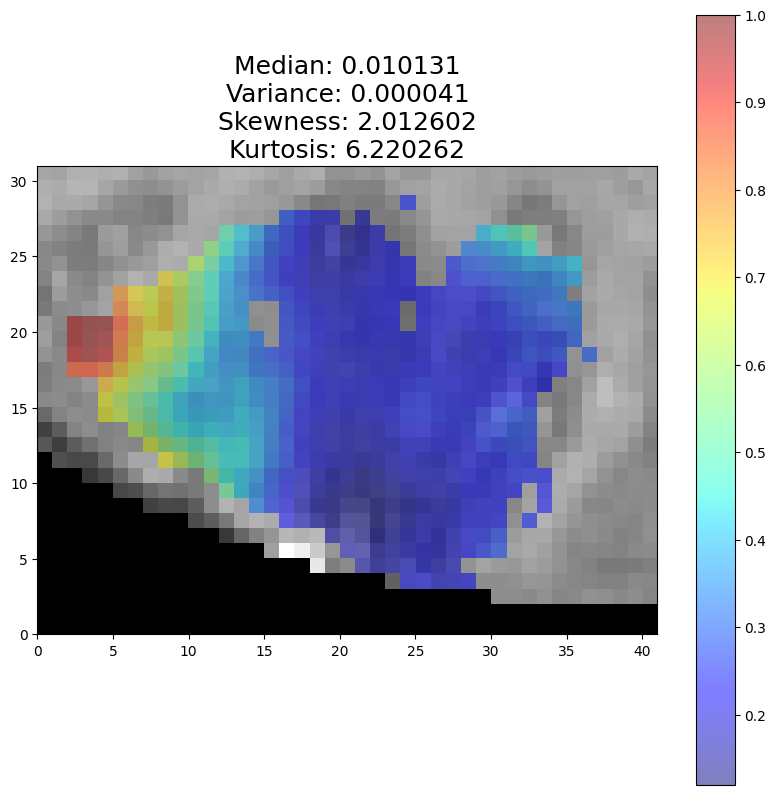

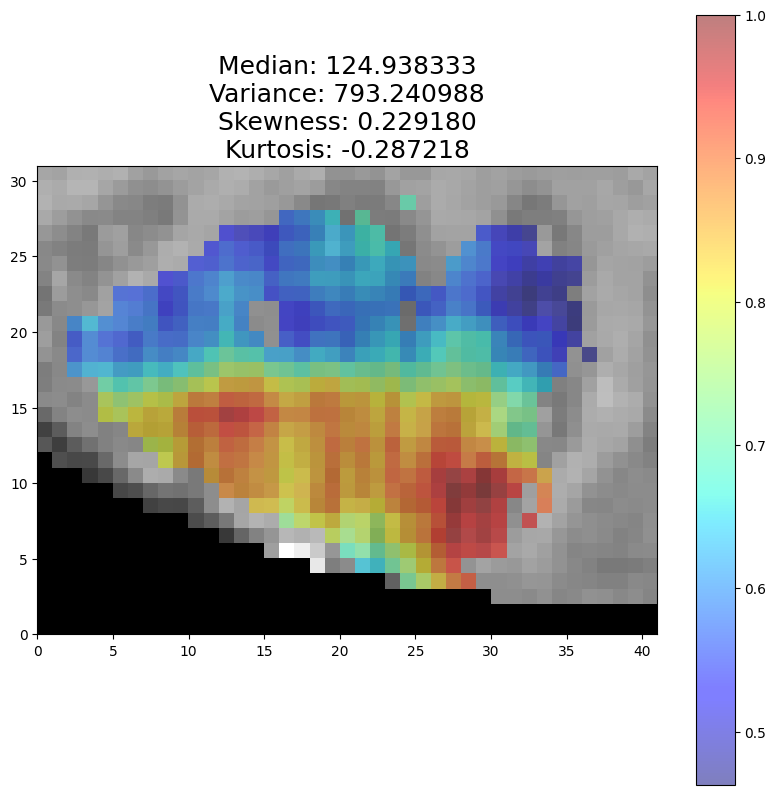

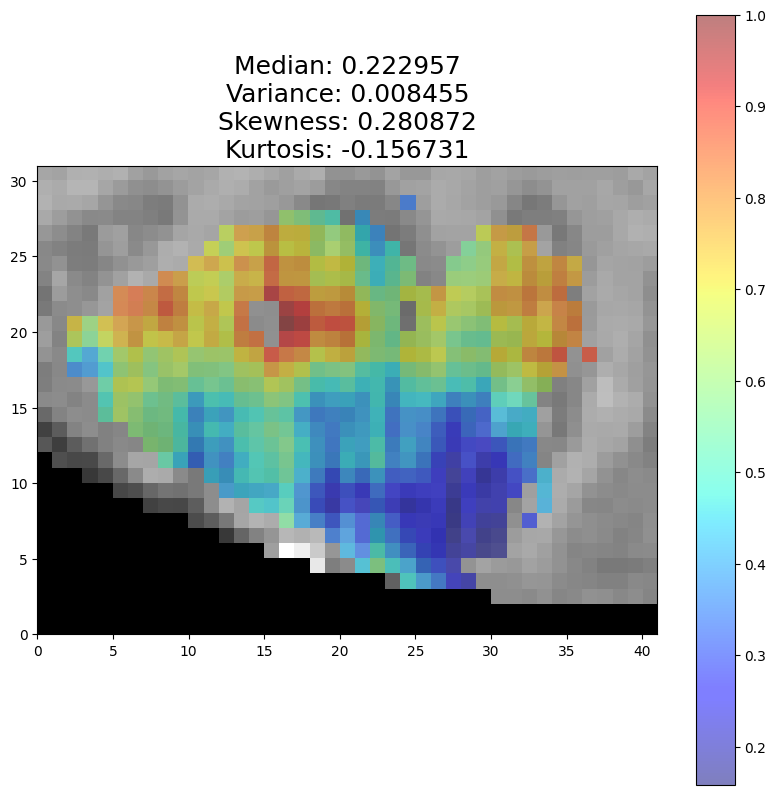

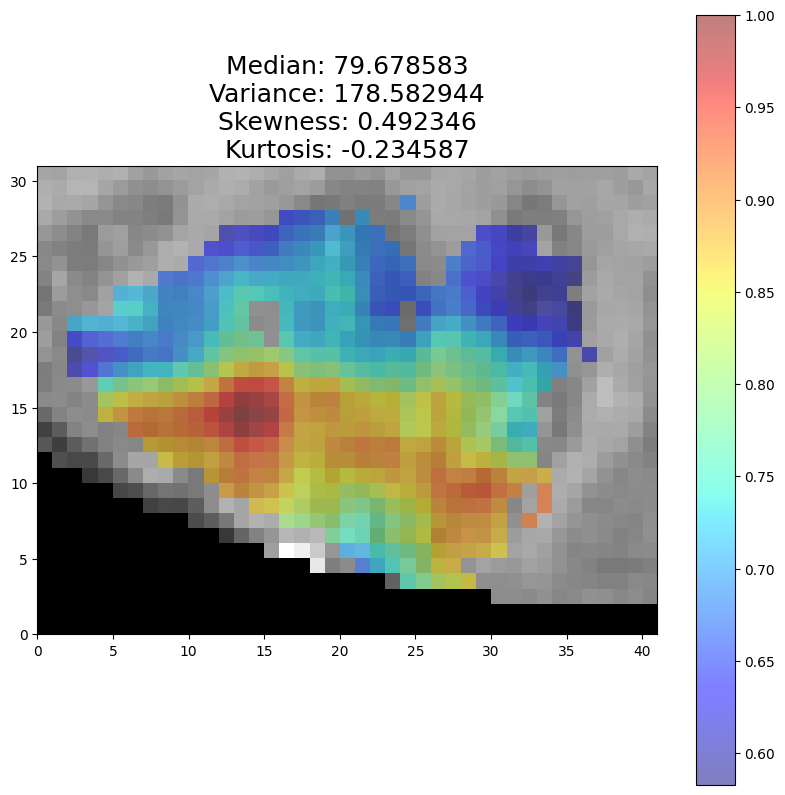

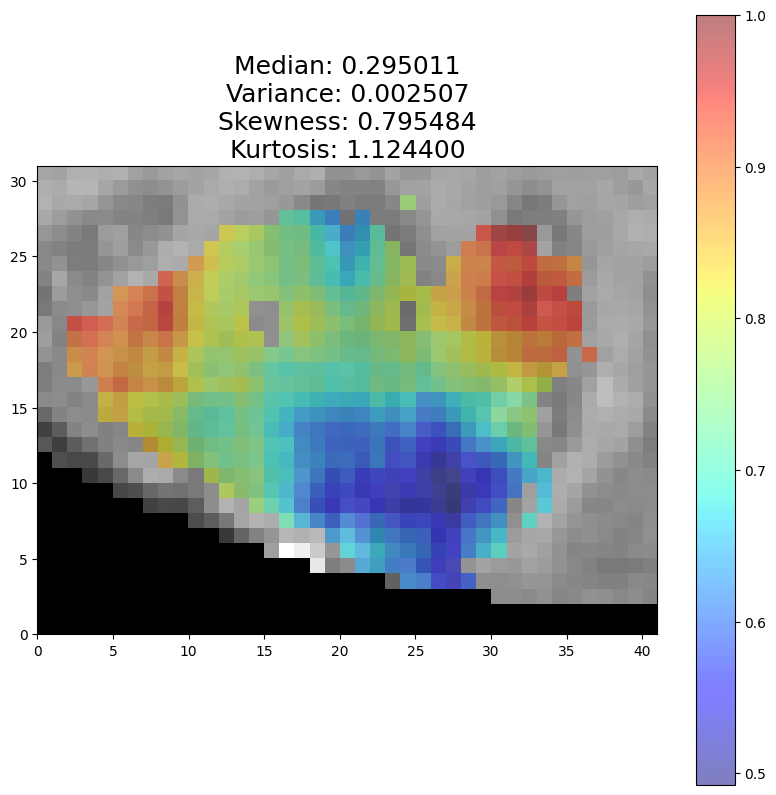

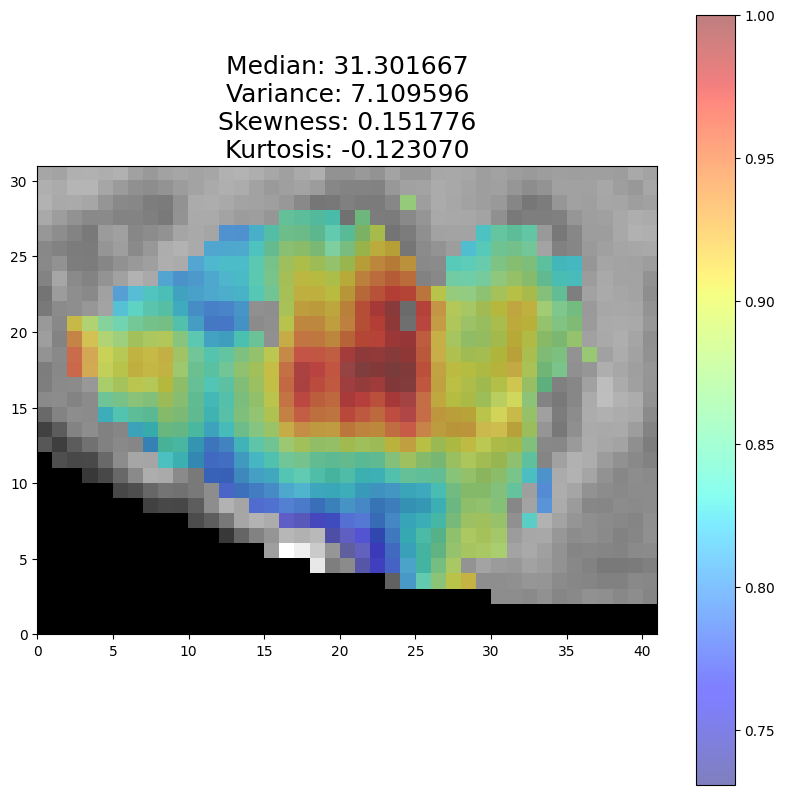

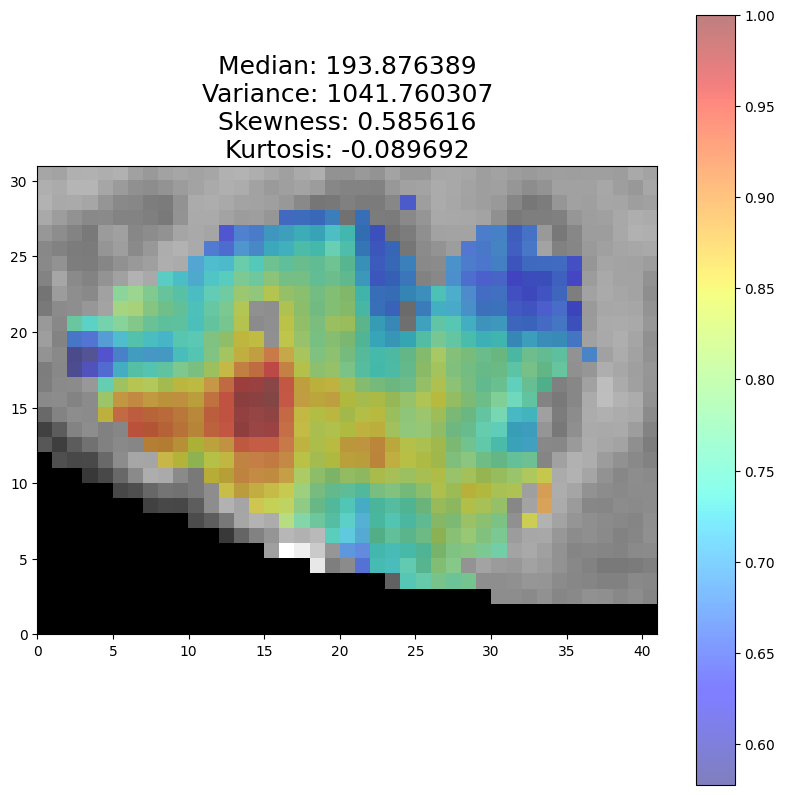

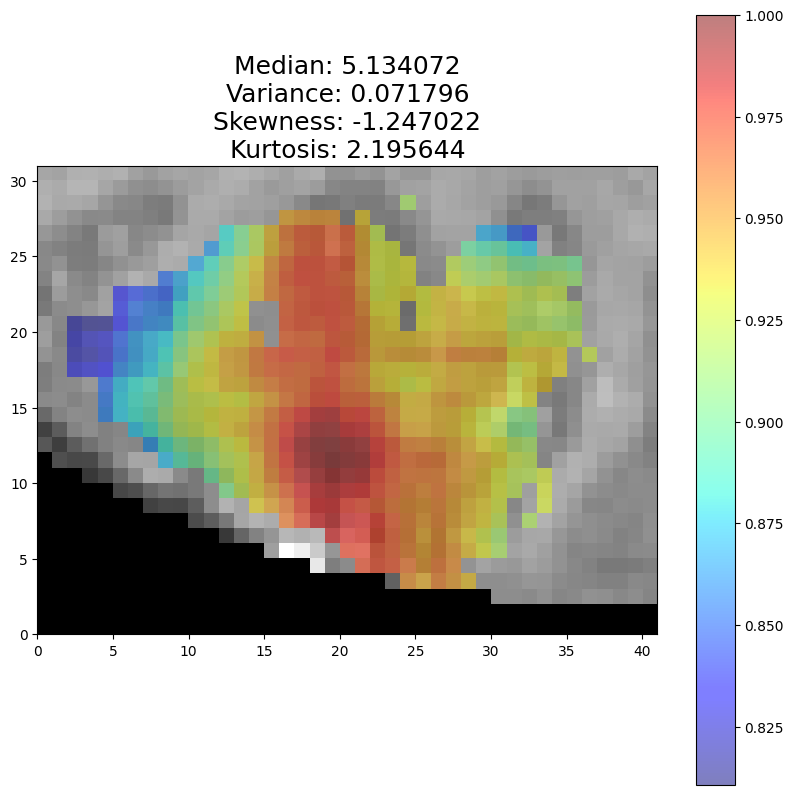

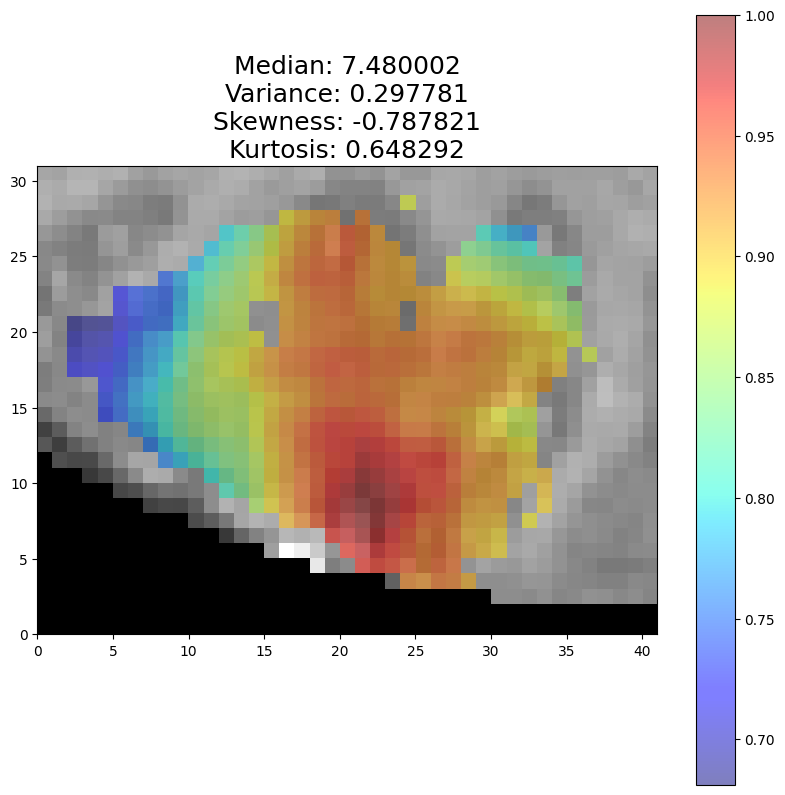

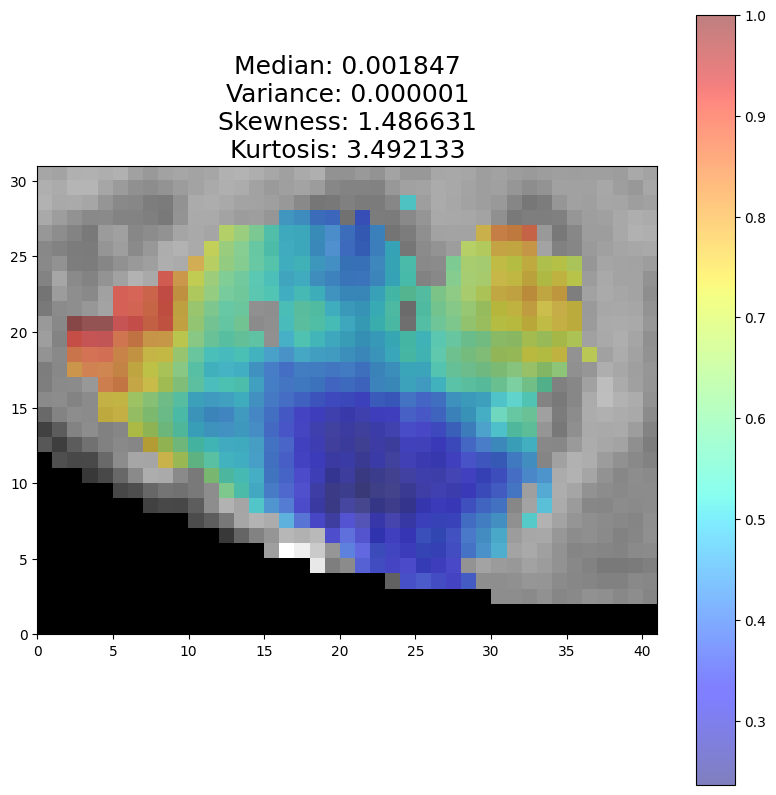

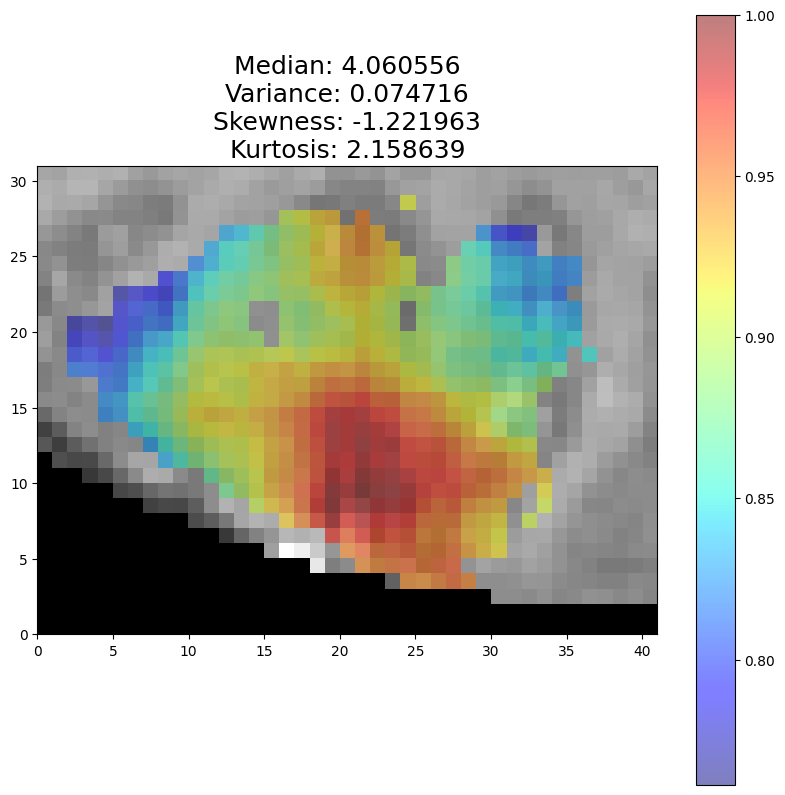

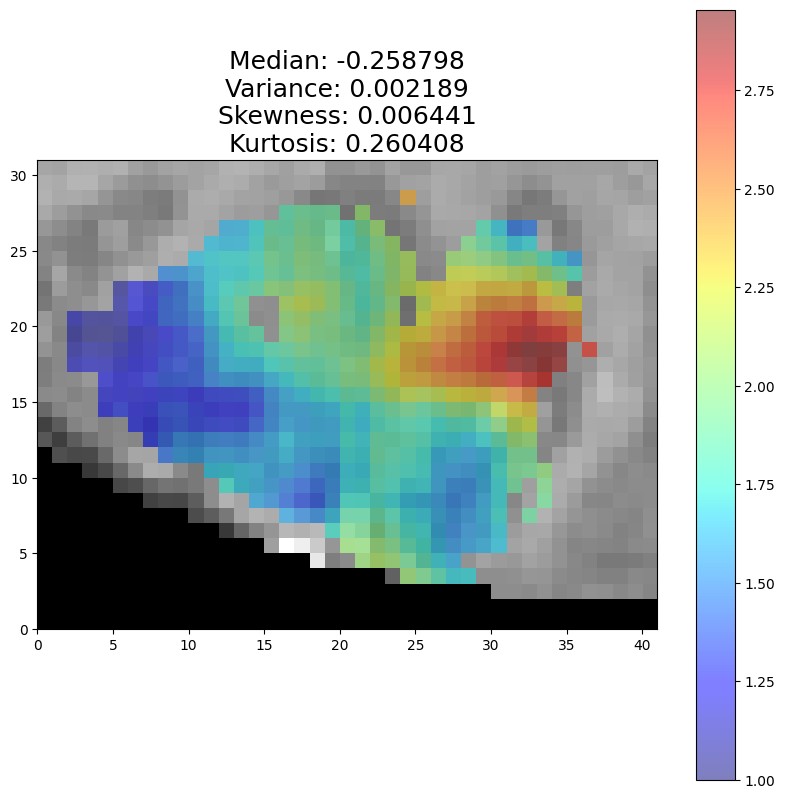

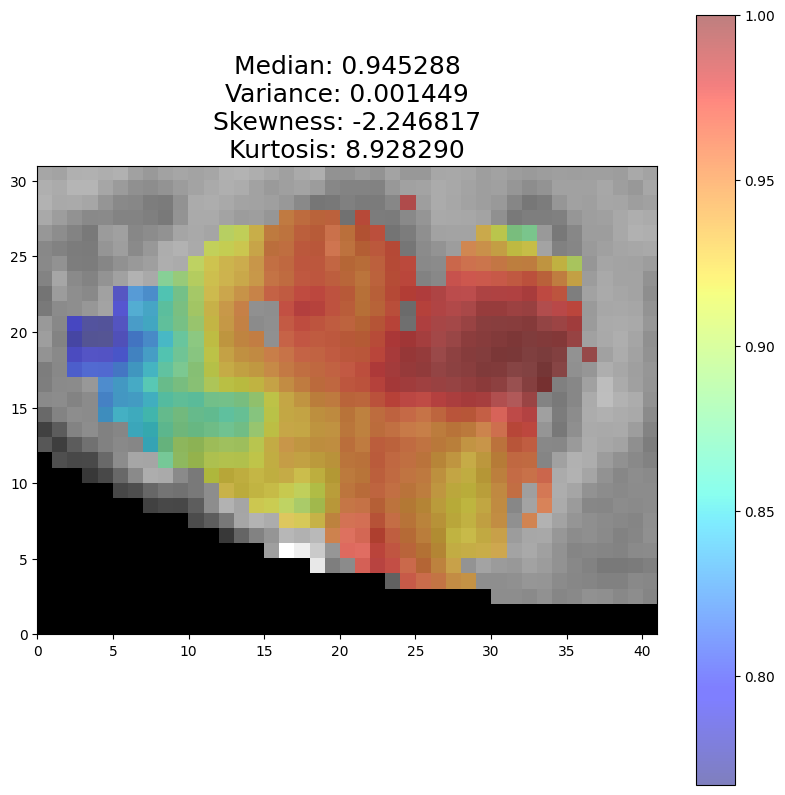

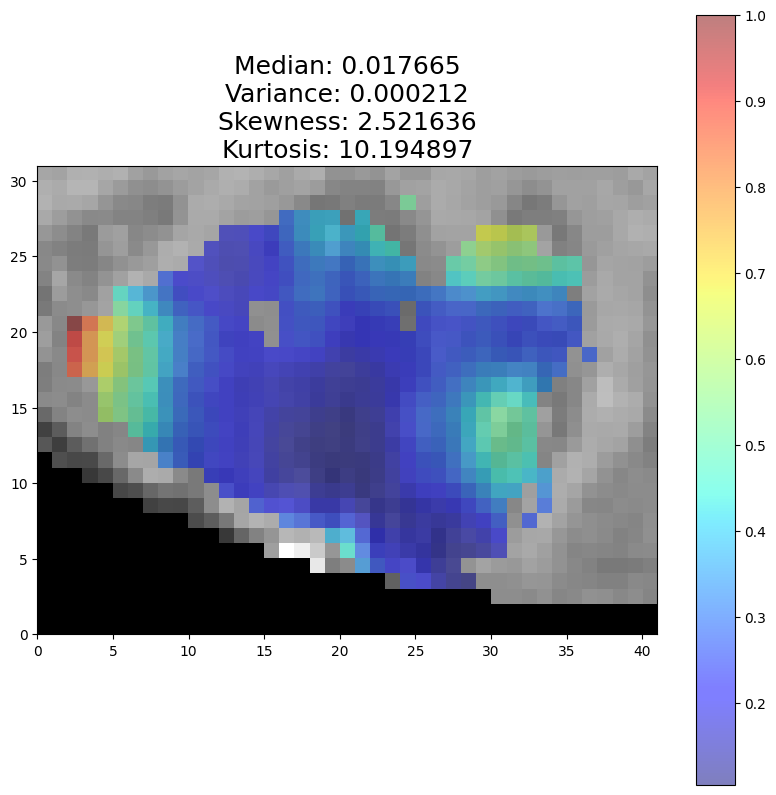

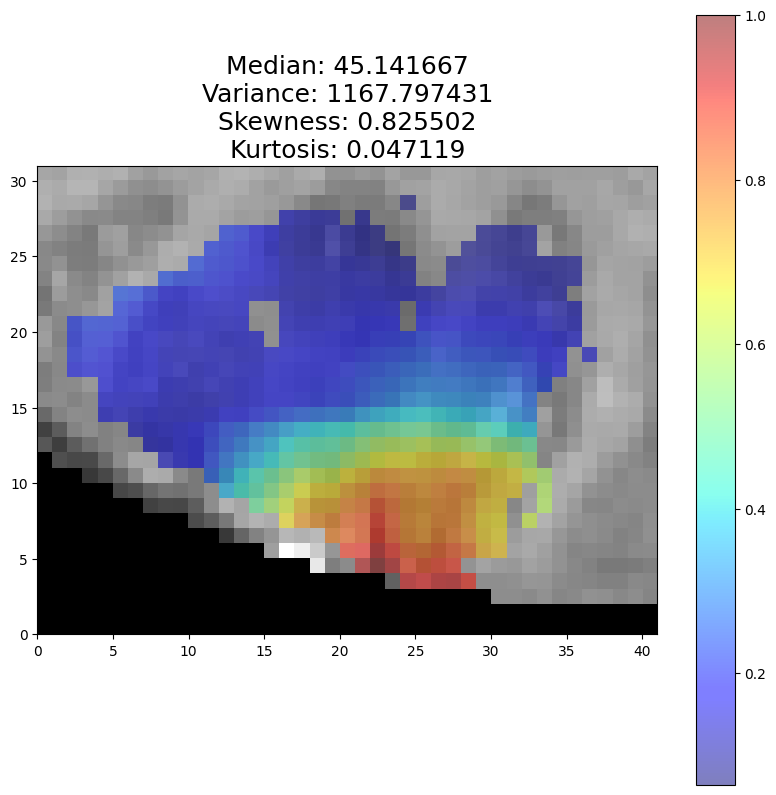

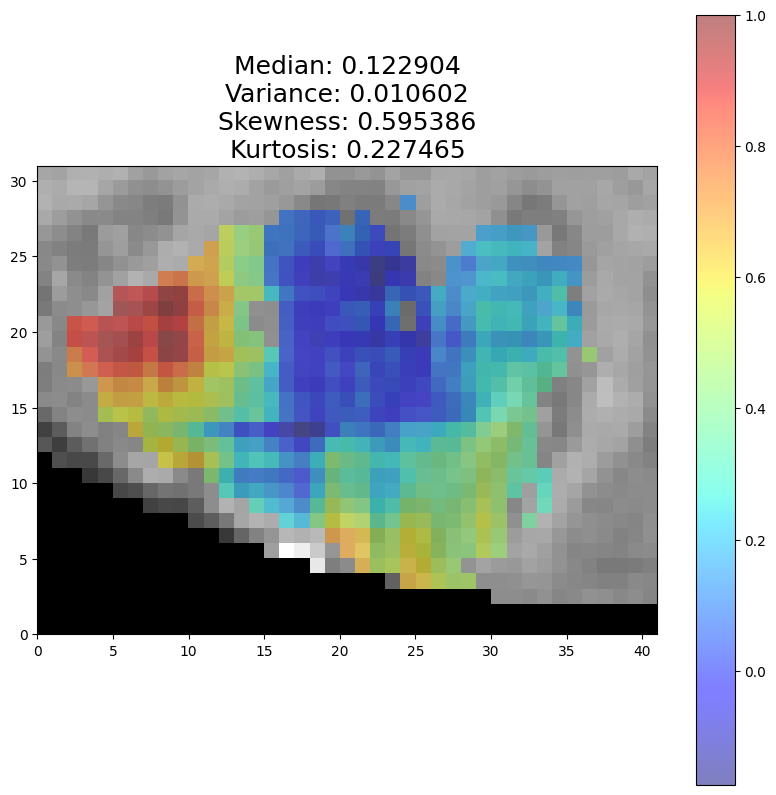

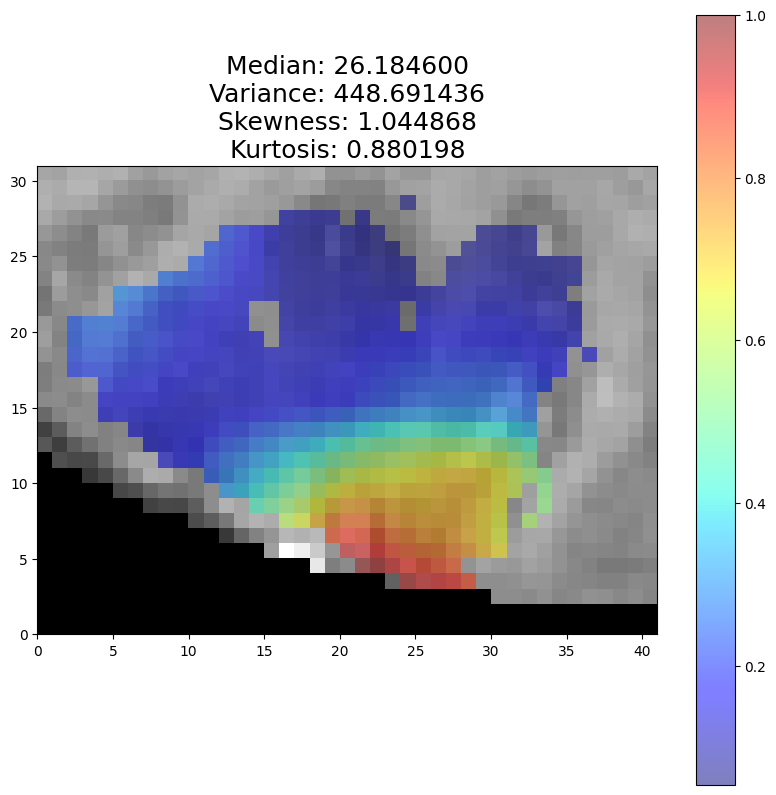

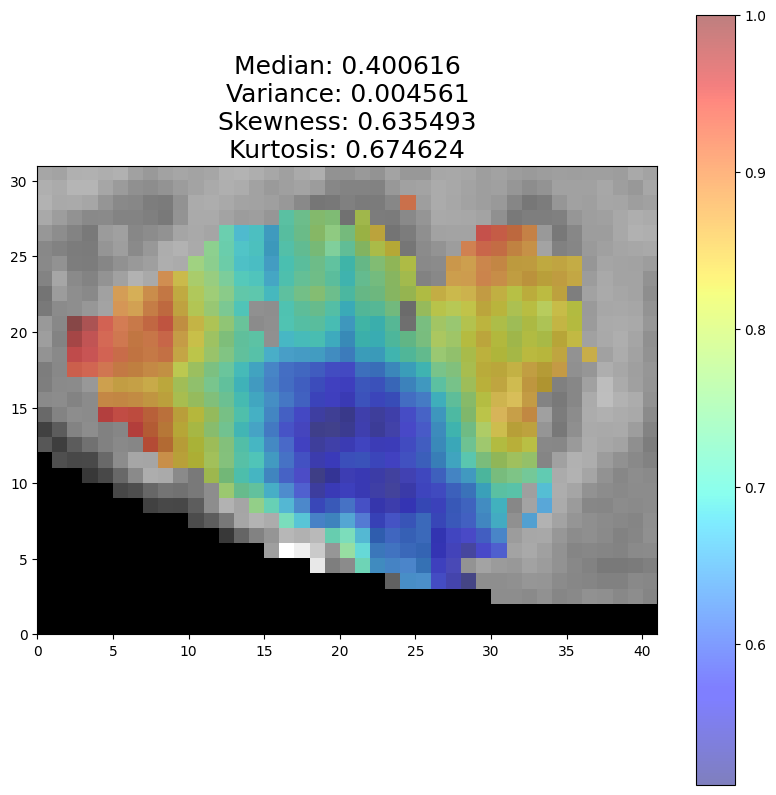

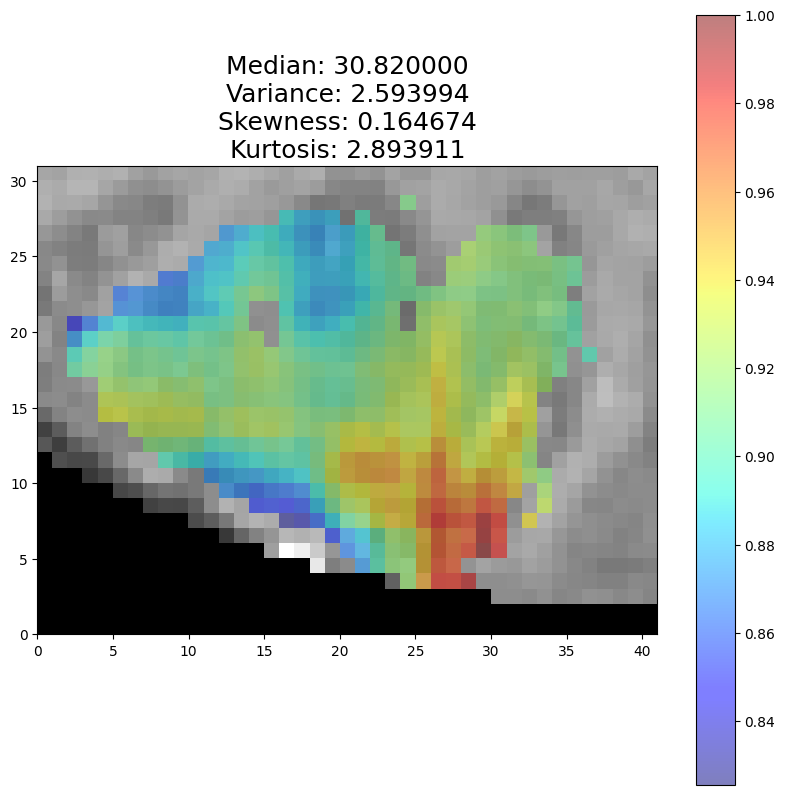

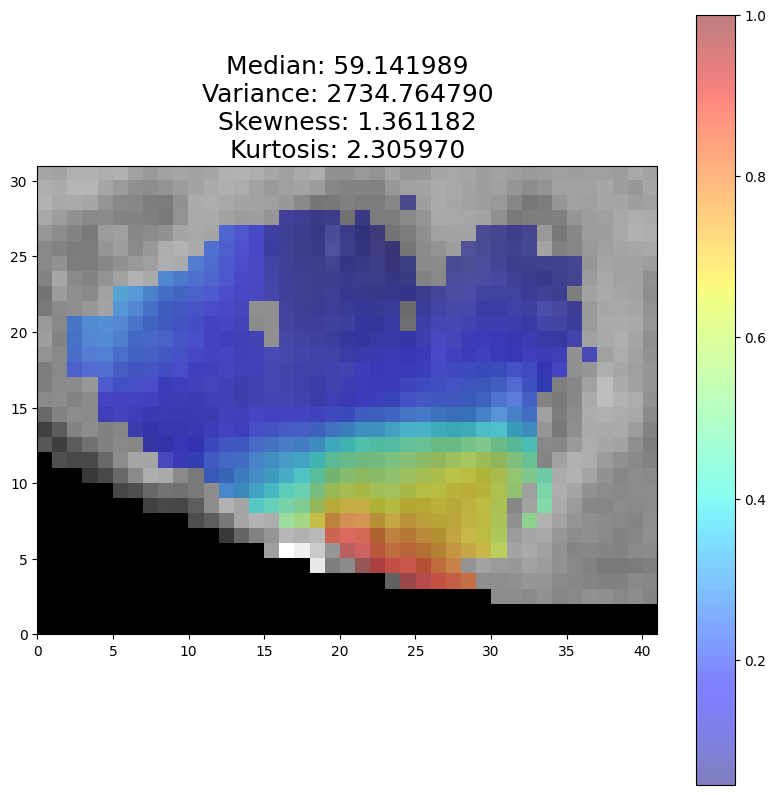

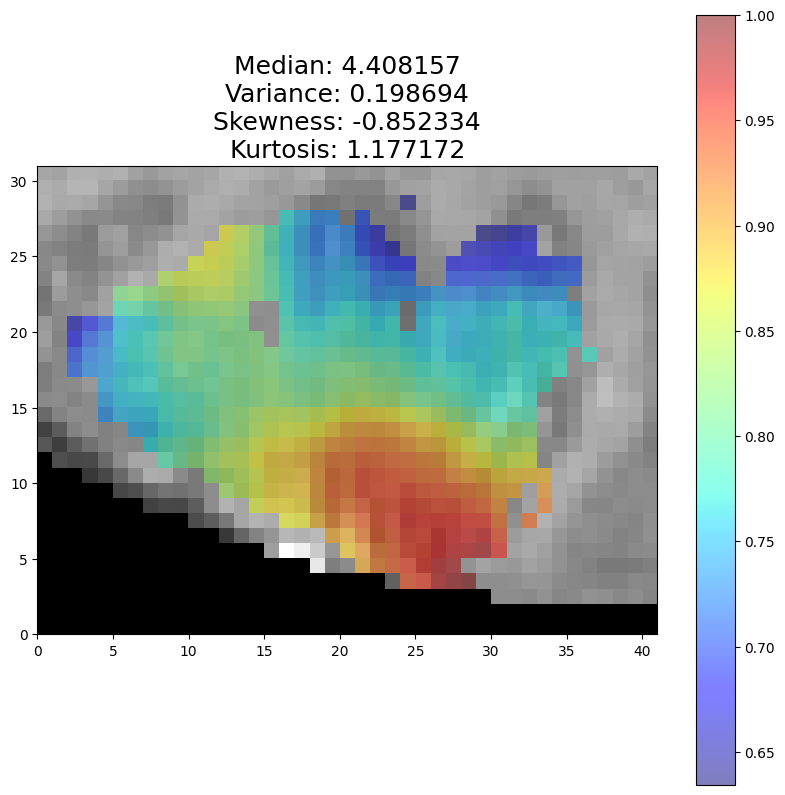

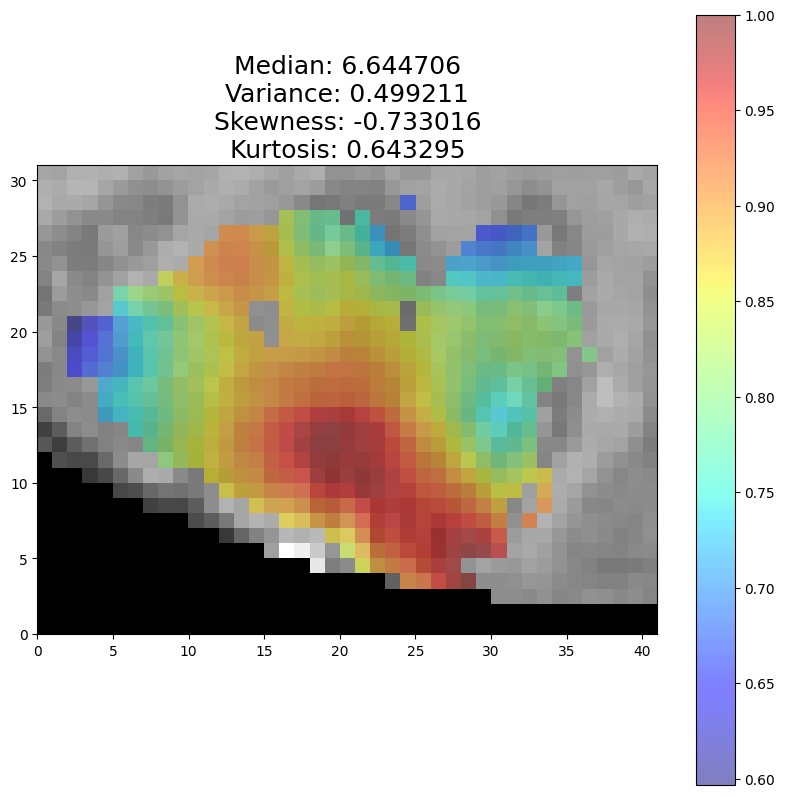

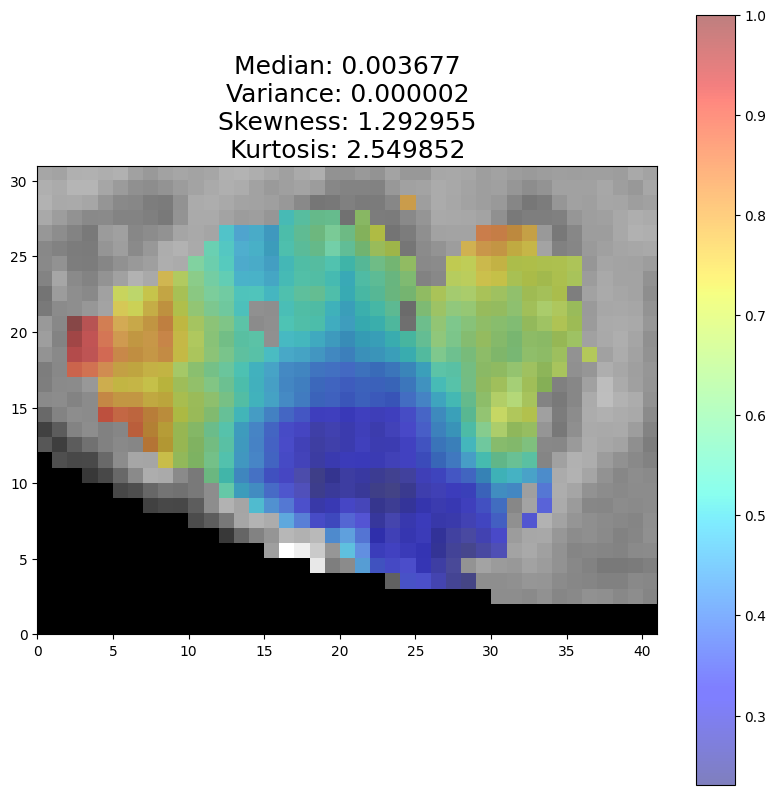

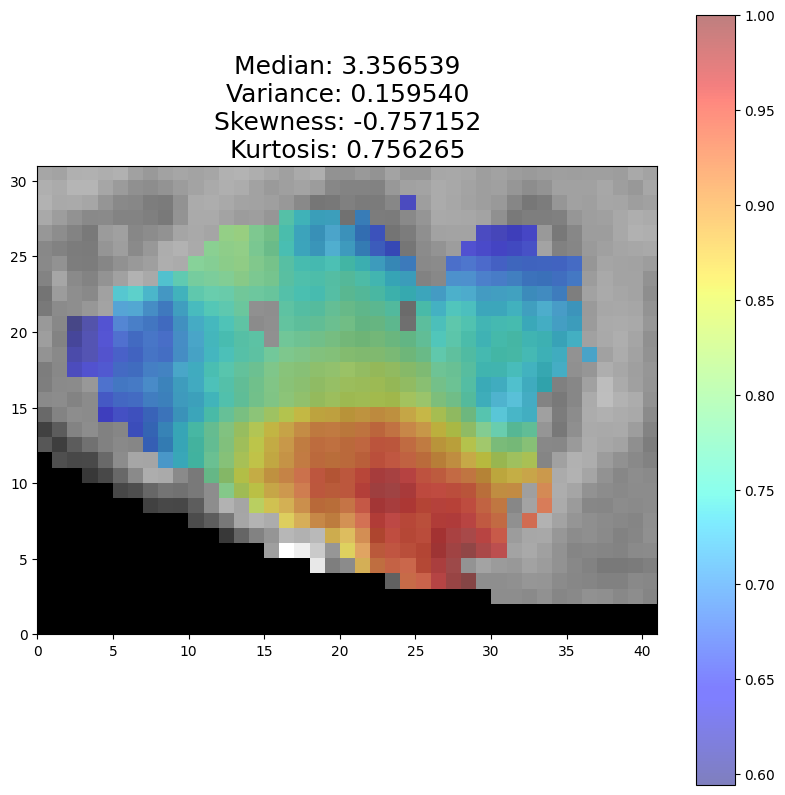

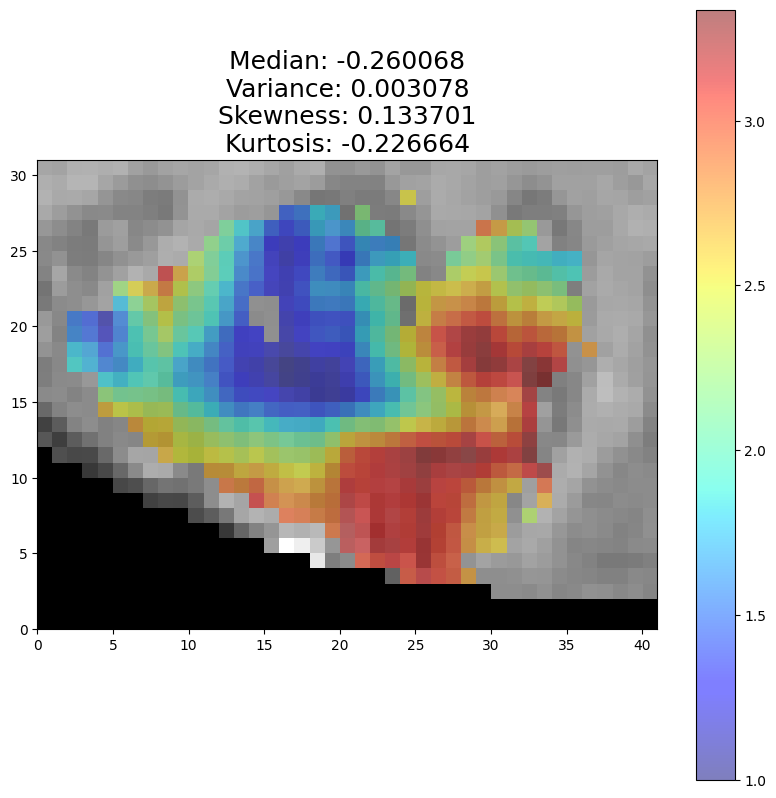

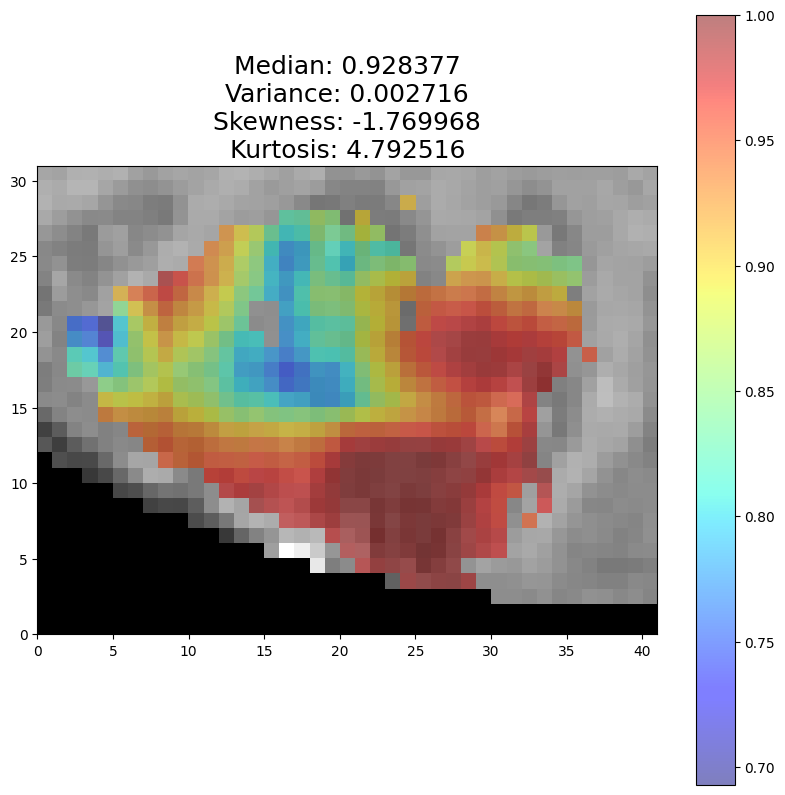

In [183]:
ids = []
ls_stats = []
for i in list(labels[id1:id2]):

    nib_mask = nib.load(i)
    mask = nib_mask.get_fdata()
    #mask = np.fliplr(np.rot90(mask)) ### correct orientation, makes generating figures easier
    for bines in binWidth:
        # defining output names (set the root directories)
        id_label = os.path.basename(os.path.dirname(os.path.dirname(i)))
        time_point = os.path.basename((os.path.dirname(i)))
        print('id_label (patient ID) ........... ',id_label)
        print('time_point (time follow up) ........... ',time_point)
        output_name=os.path.join(outpath_base , id_label , time_point ,feature_folder)
        print('output_name folder .... ',output_name)
        tmp_name =  os.path.join(output_name, mri_mod + '_' + id_label + '_' + str(bines)+'_'+ name_a + '_' + pipeline + '.npy') 
        print('tmp_name stats .npy .......',tmp_name)
        tmp_name_angle =  os.path.join(output_name, mri_mod + '_' + id_label + '_'+ str(bines)+'_' + name_a + '_' + pipeline + '_angle_output.npy') 
        print('tmp_name angles output .npy .......',tmp_name_angle)
        
        label = np.zeros((mask.shape))
        if label_val > 0:
            label[mask==label_val] = 1 ### consider only specified label
        else:
            label[mask>0] = 1 ### consider all labels

        label_vol=np.where(label==1)
        print('label_vol . ..... ',label_vol[0].shape[0])

        j = [idx for idx, fname in enumerate(imgs) if id_label + '_' + mri_mod in fname]
        if len(j)==0:
            print('mri modality doesnt exist')
            continue

        j=j[0]
        nib_image = nib.load(imgs[j])
        mri_image = nib_image.get_fdata()
        #mri_image = np.fliplr(np.rot90(mri_image)) ### correct orientation, makes generating figures easier
        label[mri_image==0] = 0

        if label_val in mask and not os.path.isfile(tmp_name):
                
            if label_vol[0].shape[0] > 50 :
                print('Calculating CoLlAGe for mask:', i)
                print('\nCalculating CoLlAGe for image:', imgs[j])
                print('Calculating CoLlAGe for label:', name_a)
                print('Calculating CoLlAGe for "n"  angular bins:', bines)

                collage = collageradiomics.Collage(mri_image, label, svd_radius=5, verbose_logging=True, num_unique_angles=bines)
                collage_output = collage.execute()

                clg_af_init = np.zeros(shape=(104,1))
                tm_dim = np.shape(collage.dominant_angles[:,:,:,0])
                clg_af, feature_angle, angle_output2 = compute_collage_stats(collage,collage_output,clg_af_init,tm_dim)
                tmp_stats = np.squeeze(clg_af.T)
                ids.append(id_label)
            else:
                print('\--------------------------insuficient voxels for computing CoLlAGe---------------------------')
                continue

        else:
            print('\nCoLlAGe already exists (npy) Label %d not found in mask for:' %label_val, id_label)
            if plot_featMap:
                collage = collageradiomics.Collage(mri_image, label, svd_radius=5, verbose_logging=True, num_unique_angles=bines)
                angle_output2 = np.load(tmp_name_angle)
                tmp_stats= np.load(tmp_name)
                for clg_angle in range(0,2):
                    for feature_index in range(0,13):
                        print(f"{feature_index}")
                        plot_collage_map_bounding(mri_image, label, angle_output2, feature_index, clg_angle, bines, mri_mod,tmp_stats, nib_image)
                #plot_collage_map(mri_image, label, collage, mri_mod)
            print('..............................................................................................................')
            
            continue

        if os.path.exists(output_name):
            print("Directory exists.")
        else:
            os.makedirs(output_name)
            print("Directory created.") 

        np.save(tmp_name, tmp_stats)
        np.save(tmp_name_angle, angle_output2)
        print('Temp CoLlAGe feature array saved.\n')

        plot_collage_map(mri_image, label, collage, mri_mod)
        plot_collage_map_bounding(mri_image, label, angle_output2,  feature_index, clg_angle, bines, mri_mod,tmp_stats, nib_image)
        print('....................................................................................................................')

In [17]:

angle_output2.shape

(128, 93, 75, 13, 2)

In [95]:
feature_list=['AngularSecondMoment','Contrast','Correlation',
                  'SumOfSquareVariance','SumAverage','SumVariance','SumEntropy',
                  'Entropy','DifferenceVariance','DifferenceEntropy',
                  'InformationMeasureOfCorrelation1','InformationMeasureOfCorrelation2',
                  'MaximalCorrelationCoefficient']
feature_list

['AngularSecondMoment',
 'Contrast',
 'Correlation',
 'SumOfSquareVariance',
 'SumAverage',
 'SumVariance',
 'SumEntropy',
 'Entropy',
 'DifferenceVariance',
 'DifferenceEntropy',
 'InformationMeasureOfCorrelation1',
 'InformationMeasureOfCorrelation2',
 'MaximalCorrelationCoefficient']

# Wrap Feature matrix from directories (.npy)

In [11]:
main_path= os.path.join(root_path , mri_data , 'Feature_extraction')
print('main outpath ..... ',main_path)

print(name_a)
print(habitat)
print(sufx)

npy_files = os.path.join(main_path,'Radiomics_features' ,'*', time_point , '*'+ feature_folder)
print('\nnpy files path ... ',(npy_files))
npy_files=glob.glob(npy_files)
npy_files=sorted(npy_files)
print('n .. folders (npy) ... ',len(npy_files))

main outpath .....  /app/Data/_Brain/Radiology/_Adult/_Glioma/xCures/Feature_extraction
Collage_Edema
Edema
ED

npy files path ...  /app/Data/_Brain/Radiology/_Adult/_Glioma/xCures/Feature_extraction/Radiomics_features/*/Baseline/*collage_pp2
n .. folders (npy) ...  13


In [12]:
dim=312 # modify according to feature extraction levels ()
id_list=[]
feature_mat=np.empty((0, dim))
id=-1
for subjects in list(npy_files[:]):
    rows=[]
    id=id+1
    case_id = os.path.basename(os.path.dirname(os.path.dirname(subjects)))
    print('case_id .....',case_id)
    feat_vect1=[]
    for bines in list([16,32,64]):
        npy_file = glob.glob(os.path.join(main_path,'Radiomics_features' ,case_id, time_point , feature_folder, mri_mod +  '_' + case_id + '_' +  str(bines) + '*' + habitat + '*IntStnd.npy'))
        # print('npy_file...',(npy_file))
        if  len(npy_file)==1:
            print((npy_file[0]))
            feat_vect=np.load(npy_file[0])
            print('feat vect .... ', feat_vect.shape)
            feat_vect1.append(feat_vect)
   
    if len(feat_vect1)<2:
        continue
            
    feat_vect1=np.squeeze(feat_vect1)    
    feat_vect1=feat_vect1.reshape(1,dim)   
    feature_mat=np.vstack((feature_mat,feat_vect1))
    id_list.append(case_id)
    print('----------------------------------------------')
print(feature_mat.shape)

case_id ..... 100_0551
case_id ..... 100_1308
/app/Data/_Brain/Radiology/_Adult/_Glioma/xCures/Feature_extraction/Radiomics_features/100_1308/Baseline/collage_pp2/T2_100_1308_16_Collage_Edema_SRI24_SkullS_BiasCorrect_IntStnd.npy
feat vect ....  (104,)
/app/Data/_Brain/Radiology/_Adult/_Glioma/xCures/Feature_extraction/Radiomics_features/100_1308/Baseline/collage_pp2/T2_100_1308_32_Collage_Edema_SRI24_SkullS_BiasCorrect_IntStnd.npy
feat vect ....  (104,)
/app/Data/_Brain/Radiology/_Adult/_Glioma/xCures/Feature_extraction/Radiomics_features/100_1308/Baseline/collage_pp2/T2_100_1308_64_Collage_Edema_SRI24_SkullS_BiasCorrect_IntStnd.npy
feat vect ....  (104,)
----------------------------------------------
case_id ..... 100_296
/app/Data/_Brain/Radiology/_Adult/_Glioma/xCures/Feature_extraction/Radiomics_features/100_296/Baseline/collage_pp2/T2_100_296_16_Collage_Edema_SRI24_SkullS_BiasCorrect_IntStnd.npy
feat vect ....  (104,)
/app/Data/_Brain/Radiology/_Adult/_Glioma/xCures/Feature_extrac

In [13]:
name_a = f'{habitat}_{feature_family}'

if mri_mod in ["T1c","CT1","T1_C"]:
    mri_mod="T1c" # making uniform across datasets

    
h_names = []
for n in range(13):
    h_names.append(collageradiomics.HaralickFeature(n).name)

s_names = ['median', 'var', 'skew', 'kurt']

names = []

for bines in list([16,32,64]):
    for g in range(2):
        for h in h_names:
            for s in s_names:
                names.append(mri_mod+'_'+s + '_' + h + '_' + str(g+1)+ '_bin_' + str(bines)+'_'+sufx)    
    
outname=os.path.join(main_path ,'Feature_matrix',time_point, mri_data + '_'+mri_mod +'_'+ name_a + '_pp2.csv')
print("raw output_file ... ",outname)
annotated_mat=outname.replace('.csv','_annots.csv')
print("annotated output_file ... ",annotated_mat)

df_mat = pd.DataFrame(np.squeeze(feature_mat), columns = names)

df_id = pd.DataFrame(id_list, columns=list(['ID']))
df_id['ID'] = df_id['ID'].astype(str)

df1=pd.concat([df_id,df_mat],axis=1)
df1.to_csv(outname, index=False)
print('feature matrix', np.squeeze(feature_mat).shape)
print('saved in ...... ', outname)
df1.head()

raw output_file ...  /app/Data/_Brain/Radiology/_Adult/_Glioma/xCures/Feature_extraction/Feature_matrix/Baseline/xCures_T2_Edema_Collage_pp2.csv
annotated output_file ...  /app/Data/_Brain/Radiology/_Adult/_Glioma/xCures/Feature_extraction/Feature_matrix/Baseline/xCures_T2_Edema_Collage_pp2_annots.csv
feature matrix (10, 312)
saved in ......  /app/Data/_Brain/Radiology/_Adult/_Glioma/xCures/Feature_extraction/Feature_matrix/Baseline/xCures_T2_Edema_Collage_pp2.csv


,ID,T2_median_AngularSecondMoment_1_bin_16_ED,T2_var_AngularSecondMoment_1_bin_16_ED,T2_skew_AngularSecondMoment_1_bin_16_ED,T2_kurt_AngularSecondMoment_1_bin_16_ED,T2_median_Contrast_1_bin_16_ED,T2_var_Contrast_1_bin_16_ED,T2_skew_Contrast_1_bin_16_ED,T2_kurt_Contrast_1_bin_16_ED,T2_median_Correlation_1_bin_16_ED,...,T2_skew_InformationMeasureOfCorrelation1_2_bin_64_ED,T2_kurt_InformationMeasureOfCorrelation1_2_bin_64_ED,T2_median_InformationMeasureOfCorrelation2_2_bin_64_ED,T2_var_InformationMeasureOfCorrelation2_2_bin_64_ED,T2_skew_InformationMeasureOfCorrelation2_2_bin_64_ED,T2_kurt_InformationMeasureOfCorrelation2_2_bin_64_ED,T2_median_MaximalCorrelationCoefficient_2_bin_64_ED,T2_var_MaximalCorrelationCoefficient_2_bin_64_ED,T2_skew_MaximalCorrelationCoefficient_2_bin_64_ED,T2_kurt_MaximalCorrelationCoefficient_2_bin_64_ED
0,100_1308,0.030213,0.000359,1.311122,3.034621,33.465000,55.219044,0.201813,0.148189,0.205204,...,-0.475211,-0.518447,-0.332403,0.003106,0.544969,-0.101978,0.978914,0.001325,-2.335931,7.132127
1,100_296,0.036576,0.000760,2.431446,10.114156,21.868669,40.888574,0.571784,0.148764,0.322132,...,-0.381873,0.321233,-0.326405,0.003552,0.314480,-0.388613,0.970983,0.001180,-1.939876,5.608766
2,100_302,0.037494,0.000666,1.971213,6.344613,24.435000,96.275618,0.423180,-0.115457,0.328714,...,-0.446872,-0.191206,-0.341588,0.002978,0.548493,0.255792,0.978869,0.000863,-2.885538,12.267110
3,100_4660,0.034242,0.000513,2.066969,7.238960,24.556667,74.841356,0.360267,-0.313584,0.286734,...,-0.521455,0.526585,-0.322534,0.002393,0.269725,0.260924,0.975643,0.000557,-2.972795,15.303908
4,100_5980,0.039163,0.001260,2.577955,10.120142,20.365000,78.268567,0.402786,-0.090242,0.338940,...,-0.312719,-0.316828,-0.335733,0.003121,0.479146,0.130866,0.975263,0.000998,-2.677081,10.612876


# Pairing feature matrix with surival annotations

In [14]:
labels_path=os.path.join(root_path , mri_data , 'Metadata',mri_data + '-labels.csv' )
print('labels_path ..... ',labels_path)
df_metadata=pd.read_csv(labels_path, dtype={0: str})

# Step 1: Merge the DataFrames based on matching identifiers (DF1['ID'] and DF2['ID1'])
merged_df = pd.merge(df1, df_metadata, left_on='ID', right_on='ID1')

# Step 2: Create the new DataFrame with desired column order
final_df = merged_df[['ID', 'x1_dead_0_alive','OS_days'] + df1.columns[1:].tolist()]

# Display the final DataFrame
final_df.to_csv(annotated_mat, index=False)
print('feature matrix', final_df.shape)
print('saved in ...... ', annotated_mat)

final_df.head()

labels_path .....  /app/Data/_Brain/Radiology/_Adult/_Glioma/xCures/Metadata/xCures-labels.csv
feature matrix (10, 315)
saved in ......  /app/Data/_Brain/Radiology/_Adult/_Glioma/xCures/Feature_extraction/Feature_matrix/Baseline/xCures_T2_Edema_Collage_pp2_annots.csv


,ID,x1_dead_0_alive,OS_days,T2_median_AngularSecondMoment_1_bin_16_ED,T2_var_AngularSecondMoment_1_bin_16_ED,T2_skew_AngularSecondMoment_1_bin_16_ED,T2_kurt_AngularSecondMoment_1_bin_16_ED,T2_median_Contrast_1_bin_16_ED,T2_var_Contrast_1_bin_16_ED,T2_skew_Contrast_1_bin_16_ED,...,T2_skew_InformationMeasureOfCorrelation1_2_bin_64_ED,T2_kurt_InformationMeasureOfCorrelation1_2_bin_64_ED,T2_median_InformationMeasureOfCorrelation2_2_bin_64_ED,T2_var_InformationMeasureOfCorrelation2_2_bin_64_ED,T2_skew_InformationMeasureOfCorrelation2_2_bin_64_ED,T2_kurt_InformationMeasureOfCorrelation2_2_bin_64_ED,T2_median_MaximalCorrelationCoefficient_2_bin_64_ED,T2_var_MaximalCorrelationCoefficient_2_bin_64_ED,T2_skew_MaximalCorrelationCoefficient_2_bin_64_ED,T2_kurt_MaximalCorrelationCoefficient_2_bin_64_ED
0,100_1308,0.0,284.0,0.030213,0.000359,1.311122,3.034621,33.465000,55.219044,0.201813,...,-0.475211,-0.518447,-0.332403,0.003106,0.544969,-0.101978,0.978914,0.001325,-2.335931,7.132127
1,100_296,1.0,650.0,0.036576,0.000760,2.431446,10.114156,21.868669,40.888574,0.571784,...,-0.381873,0.321233,-0.326405,0.003552,0.314480,-0.388613,0.970983,0.001180,-1.939876,5.608766
2,100_302,1.0,506.0,0.037494,0.000666,1.971213,6.344613,24.435000,96.275618,0.423180,...,-0.446872,-0.191206,-0.341588,0.002978,0.548493,0.255792,0.978869,0.000863,-2.885538,12.267110
3,100_4660,1.0,388.0,0.034242,0.000513,2.066969,7.238960,24.556667,74.841356,0.360267,...,-0.521455,0.526585,-0.322534,0.002393,0.269725,0.260924,0.975643,0.000557,-2.972795,15.303908
4,100_5980,0.0,119.0,0.039163,0.001260,2.577955,10.120142,20.365000,78.268567,0.402786,...,-0.312719,-0.316828,-0.335733,0.003121,0.479146,0.130866,0.975263,0.000998,-2.677081,10.612876
